In [ ]:
# temp time check - remove before submission
import datetime
begin_time = datetime.datetime.now()

## Environment setup

The code in section 1.1 is a repeat of the code in the first EDA notebook in order to bring in the data.

In [ ]:
DATA_DIR = "../data/home-credit-default-risk"  # data folder will be present in the level as the code folder

# Google colab start ( below two cells need to comment out if run in PC)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set the data directory
#DATA_DIR = "../data/home-credit-default-risk"  # data folder will be present in the level as the code folder
DATA_DIR = "/content/drive/MyDrive/data/home-credit-default-risk"

# set the directory for storing model objects
#MODEL_DIR = "../output/models"
MODEL_DIR = "/content/drive/MyDrive/output/models"

# set the results folder for storing model results
#REPORT_DIR = "../output/reports"
REPORT_DIR = "/content/drive/MyDrive/output/reports"

# set the submission folder
SUBMISSION_DIR = "/content/drive/MyDrive/output/submissions"

# Google colab setting end

In [ ]:
# data manipulation
import numpy as np
import pandas as pd 

import os
import zipfile

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# splitting
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder

# pipelines
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# tuning
from sklearn.model_selection import GridSearchCV, cross_val_score
#from skopt import BayesSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
import re
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)



datasets={}  # data will be stored in a dictionary

# Functions

In [ ]:
def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    display(df.head(5))
    return df

In [ ]:
# create a function to plot feature importances
def lr_feature_importance_plot(clf, names, n=10):
    feature_importance = abs(clf.named_steps['logistic'].coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(1, 1, 1)
    ax.barh(pos[-n:], feature_importance[sorted_idx][-n:], align='center')
    ax.set_yticks(pos[-n:])
    ax.set_yticklabels(np.array(names)[sorted_idx][-n:], fontsize=8)
    ax.set_xlabel('Relative Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    print("There are",len(feature_importance[feature_importance == 0]),"features that have 0 importance.")

In [ ]:
# create a function to plot feature importances for tree model
def tree_feature_importance_plot(clf, step_name, names, n=10):
    feature_importance = abs(clf.named_steps[step_name].feature_importances_)
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(1, 1, 1)
    ax.barh(pos[-n:], feature_importance[sorted_idx][-n:], align='center')
    ax.set_yticks(pos[-n:])
    ax.set_yticklabels(np.array(names)[sorted_idx][-n:], fontsize=8)
    ax.set_xlabel('Relative Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    print("There are",len(feature_importance[feature_importance == 0]),"features that have 0 importance.")

## Data Load

In [ ]:
%%time
ds_names = ("train_clean", "test_clean")

for ds_name in ds_names:
    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

train_clean: shape is (307511, 618)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 618 entries, Unnamed: 0 to HAS_LIBAILITY
dtypes: float64(562), int64(41), object(15)
memory usage: 1.4+ GB
None


,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,YEARS_BEGINEXPLUATATION_MEDI,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREV_AMT_ANNUITY_min,PREV_AMT_ANNUITY_max,PREV_AMT_ANNUITY_mean,PREV_AMT_ANNUITY_count,PREV_AMT_ANNUITY_sum,PREV_AMT_APPLICATION_min,PREV_AMT_APPLICATION_max,PREV_AMT_APPLICATION_mean,PREV_AMT_DOWN_PAYMENT_min,PREV_AMT_DOWN_PAYMENT_max,PREV_AMT_DOWN_PAYMENT_count,PREV_AMT_GOODS_PRICE_min,PREV_HOUR_APPR_PROCESS_START_min,PREV_HOUR_APPR_PROCESS_START_max,PREV_HOUR_APPR_PROCESS_START_mean,PREV_NFLAG_LAST_APPL_IN_DAY_min,PREV_NFLAG_LAST_APPL_IN_DAY_max,PREV_NFLAG_LAST_APPL_IN_DAY_mean,PREV_RATE_DOWN_PAYMENT_min,PREV_RATE_DOWN_PAYMENT_max,PREV_RATE_DOWN_PAYMENT_mean,PREV_RATE_DOWN_PAYMENT_sum,PREV_RATE_INTEREST_PRIMARY_count,PREV_DAYS_DECISION_min,PREV_DAYS_DECISION_max,PREV_DAYS_DECISION_mean,PREV_DAYS_DECISION_sum,PREV_SELLERPLACE_AREA_min,PREV_SELLERPLACE_AREA_max,PREV_SELLERPLACE_AREA_mean,PREV_SELLERPLACE_AREA_sum,PREV_CNT_PAYMENT_min,PREV_CNT_PAYMENT_max,PREV_CNT_PAYMENT_mean,PREV_CNT_PAYMENT_sum,PREV_DAYS_FIRST_DRAWING_min,PREV_DAYS_FIRST_DRAWING_max,PREV_DAYS_FIRST_DRAWING_mean,PREV_DAYS_FIRST_DRAWING_count,PREV_DAYS_FIRST_DUE_min,PREV_DAYS_FIRST_DUE_max,PREV_DAYS_FIRST_DUE_mean,PREV_DAYS_LAST_DUE_1ST_VERSION_max,PREV_DAYS_LAST_DUE_1ST_VERSION_mean,PREV_DAYS_LAST_DUE_min,PREV_DAYS_LAST_DUE_max,PREV_DAYS_LAST_DUE_mean,PREV_DAYS_LAST_DUE_sum,PREV_NFLAG_INSURED_ON_APPROVAL_min,PREV_NFLAG_INSURED_ON_APPROVAL_max,PREV_NFLAG_INSURED_ON_APPROVAL_mean,PREV_NFLAG_INSURED_ON_APPROVAL_sum,PREV_POS_MONTHS_BALANCE_min_max,PREV_POS_MONTHS_BALANCE_min_mean,PREV_POS_MONTHS_BALANCE_min_sum,PREV_POS_MONTHS_BALANCE_count_min,PREV_POS_MONTHS_BALANCE_count_max,PREV_POS_MONTHS_BALANCE_count_mean,PREV_POS_MONTHS_BALANCE_count_sum,PREV_POS_MONTHS_BALANCE_sum_min,PREV_POS_MONTHS_BALANCE_sum_max,PREV_POS_MONTHS_BALANCE_sum_mean,PREV_POS_CNT_INSTALMENT_min_min,PREV_POS_CNT_INSTALMENT_min_max,PREV_POS_CNT_INSTALMENT_min_mean,PREV_POS_CNT_INSTALMENT_max_min,PREV_POS_CNT_INSTALMENT_max_max,PREV_POS_CNT_INSTALMENT_max_mean,PREV_POS_CNT_INSTALMENT_max_sum,PREV_POS_CNT_INSTALMENT_sum_min,PREV_POS_CNT_INSTALMENT_sum_max,PREV_POS_CNT_INSTALMENT_sum_mean,PREV_POS_CNT_INSTALMENT_sum_sum,PREV_POS_CNT_INSTALMENT_FUTURE_min_min,PREV_POS_CNT_INSTALMENT_FUTURE_min_max,PREV_POS_CNT_INSTALMENT_FUTURE_min_mean,PREV_POS_SK_DPD_min_max,PREV_POS_SK_DPD_min_mean,PREV_POS_SK_DPD_min_sum,PREV_POS_SK_DPD_max_min,PREV_POS_SK_DPD_max_max,PREV_POS_SK_DPD_DEF_min_max,PREV_POS_SK_DPD_DEF_min_mean,PREV_POS_SK_DPD_DEF_min_sum,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Active_

test_clean: shape is (48744, 617)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 617 entries, Unnamed: 0 to HAS_LIBAILITY
dtypes: float64(562), int64(40), object(15)
memory usage: 229.5+ MB
None


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,YEARS_BEGINEXPLUATATION_MEDI,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREV_AMT_ANNUITY_min,PREV_AMT_ANNUITY_max,PREV_AMT_ANNUITY_mean,PREV_AMT_ANNUITY_count,PREV_AMT_ANNUITY_sum,PREV_AMT_APPLICATION_min,PREV_AMT_APPLICATION_max,PREV_AMT_APPLICATION_mean,PREV_AMT_DOWN_PAYMENT_min,PREV_AMT_DOWN_PAYMENT_max,PREV_AMT_DOWN_PAYMENT_count,PREV_AMT_GOODS_PRICE_min,PREV_HOUR_APPR_PROCESS_START_min,PREV_HOUR_APPR_PROCESS_START_max,PREV_HOUR_APPR_PROCESS_START_mean,PREV_NFLAG_LAST_APPL_IN_DAY_min,PREV_NFLAG_LAST_APPL_IN_DAY_max,PREV_NFLAG_LAST_APPL_IN_DAY_mean,PREV_RATE_DOWN_PAYMENT_min,PREV_RATE_DOWN_PAYMENT_max,PREV_RATE_DOWN_PAYMENT_mean,PREV_RATE_DOWN_PAYMENT_sum,PREV_RATE_INTEREST_PRIMARY_count,PREV_DAYS_DECISION_min,PREV_DAYS_DECISION_max,PREV_DAYS_DECISION_mean,PREV_DAYS_DECISION_sum,PREV_SELLERPLACE_AREA_min,PREV_SELLERPLACE_AREA_max,PREV_SELLERPLACE_AREA_mean,PREV_SELLERPLACE_AREA_sum,PREV_CNT_PAYMENT_min,PREV_CNT_PAYMENT_max,PREV_CNT_PAYMENT_mean,PREV_CNT_PAYMENT_sum,PREV_DAYS_FIRST_DRAWING_min,PREV_DAYS_FIRST_DRAWING_max,PREV_DAYS_FIRST_DRAWING_mean,PREV_DAYS_FIRST_DRAWING_count,PREV_DAYS_FIRST_DUE_min,PREV_DAYS_FIRST_DUE_max,PREV_DAYS_FIRST_DUE_mean,PREV_DAYS_LAST_DUE_1ST_VERSION_max,PREV_DAYS_LAST_DUE_1ST_VERSION_mean,PREV_DAYS_LAST_DUE_min,PREV_DAYS_LAST_DUE_max,PREV_DAYS_LAST_DUE_mean,PREV_DAYS_LAST_DUE_sum,PREV_NFLAG_INSURED_ON_APPROVAL_min,PREV_NFLAG_INSURED_ON_APPROVAL_max,PREV_NFLAG_INSURED_ON_APPROVAL_mean,PREV_NFLAG_INSURED_ON_APPROVAL_sum,PREV_POS_MONTHS_BALANCE_min_max,PREV_POS_MONTHS_BALANCE_min_mean,PREV_POS_MONTHS_BALANCE_min_sum,PREV_POS_MONTHS_BALANCE_count_min,PREV_POS_MONTHS_BALANCE_count_max,PREV_POS_MONTHS_BALANCE_count_mean,PREV_POS_MONTHS_BALANCE_count_sum,PREV_POS_MONTHS_BALANCE_sum_min,PREV_POS_MONTHS_BALANCE_sum_max,PREV_POS_MONTHS_BALANCE_sum_mean,PREV_POS_CNT_INSTALMENT_min_min,PREV_POS_CNT_INSTALMENT_min_max,PREV_POS_CNT_INSTALMENT_min_mean,PREV_POS_CNT_INSTALMENT_max_min,PREV_POS_CNT_INSTALMENT_max_max,PREV_POS_CNT_INSTALMENT_max_mean,PREV_POS_CNT_INSTALMENT_max_sum,PREV_POS_CNT_INSTALMENT_sum_min,PREV_POS_CNT_INSTALMENT_sum_max,PREV_POS_CNT_INSTALMENT_sum_mean,PREV_POS_CNT_INSTALMENT_sum_sum,PREV_POS_CNT_INSTALMENT_FUTURE_min_min,PREV_POS_CNT_INSTALMENT_FUTURE_min_max,PREV_POS_CNT_INSTALMENT_FUTURE_min_mean,PREV_POS_SK_DPD_min_max,PREV_POS_SK_DPD_min_mean,PREV_POS_SK_DPD_min_sum,PREV_POS_SK_DPD_max_min,PREV_POS_SK_DPD_max_max,PREV_POS_SK_DPD_DEF_min_max,PREV_POS_SK_DPD_DEF_min_mean,PREV_POS_SK_DPD_DEF_min_sum,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_ma

CPU times: user 26.7 s, sys: 3.79 s, total: 30.5 s
Wall time: 34.5 s


In [ ]:
for ds_name in datasets.keys():
    print(f'dataset {ds_name:24}: [ {datasets[ds_name].shape[0]:10,}, {datasets[ds_name].shape[1]}]')

dataset train_clean             : [    307,511, 618]
dataset test_clean              : [     48,744, 617]


In [ ]:
appTrainDF = datasets["train_clean"]
appTestDF = datasets["test_clean"]

In [ ]:
# delete objects no longer needed for memory
import gc
gc.enable()
del datasets
gc.collect()

150

## Split data

In [ ]:
# assign the input and response features
X = appTrainDF.drop(['SK_ID_CURR', 'TARGET'], axis = 1)
y = appTrainDF['TARGET']

In [ ]:
# split data such that 80% in training and 20% in test
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)

In [ ]:
x_train.shape

(246008, 616)

### Generate a smaller sample for tuning

A standard 4 Core and 16 GB RAM does not have enough compute power to train a model of this size. Thus we will do an additional split with the training data in order for performing hyperparameter tuning. <br>

The hyperparameter tuning will be completed using a random 10% of the training data. The hyperparameters will be chosen based on the subset generating the highest 5 fold validation area under the roc curve. <br>

We will use the remaining 90% of the training data to perform 5 fold cross validation with the best hyperparameters from the tuning process to gather estimates of how the model will perform on unseen data.

In [ ]:
# split data such that 10% is used for tuning, other 90% used for cross fold validation with best hyperparameters
x_sample_10, x_sample_90, y_sample_10, y_sample_90 = train_test_split(x_train, y_train, stratify=y_train, test_size=.9, random_state=42)

In [ ]:
x_sample_10.shape

(24600, 616)

In [ ]:
numerical_features=[]
categorical_features =[]
categorical_features=categorical_features + appTrainDF.select_dtypes(include='object').columns.tolist()
numerical_features=numerical_features + appTrainDF.select_dtypes(exclude='object').columns.tolist()
numerical_features.remove('SK_ID_CURR')
numerical_features.remove('TARGET')



### Set logistic pipeline

In [ ]:
# create pipeline for numeric features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# create pipeline for categorical features
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value="Unknown")),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

# specify the column transformer for numeric and categorical features
data_pipeline = ColumnTransformer(
    [("num_pipeline", num_pipeline, numerical_features),
    ("cat_pipeline", cat_pipeline, categorical_features)],
    remainder='passthrough')

In [ ]:
# test the transformer


X_train_transformed = data_pipeline.fit_transform(x_train)

column_names = numerical_features  + \
               list(data_pipeline.transformers_[1][1].named_steps["ohe"].get_feature_names(categorical_features))

display(pd.DataFrame(X_train_transformed,  columns=column_names).head())

,Unnamed: 0,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,YEARS_BEGINEXPLUATATION_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREV_AMT_ANNUITY_min,PREV_AMT_ANNUITY_max,PREV_AMT_ANNUITY_mean,PREV_AMT_ANNUITY_count,PREV_AMT_ANNUITY_sum,PREV_AMT_APPLICATION_min,PREV_AMT_APPLICATION_max,PREV_AMT_APPLICATION_mean,PREV_AMT_DOWN_PAYMENT_min,PREV_AMT_DOWN_PAYMENT_max,PREV_AMT_DOWN_PAYMENT_count,PREV_AMT_GOODS_PRICE_min,PREV_HOUR_APPR_PROCESS_START_min,PREV_HOUR_APPR_PROCESS_START_max,PREV_HOUR_APPR_PROCESS_START_mean,PREV_NFLAG_LAST_APPL_IN_DAY_min,PREV_NFLAG_LAST_APPL_IN_DAY_max,PREV_NFLAG_LAST_APPL_IN_DAY_mean,PREV_RATE_DOWN_PAYMENT_min,PREV_RATE_DOWN_PAYMENT_max,PREV_RATE_DOWN_PAYMENT_mean,PREV_RATE_DOWN_PAYMENT_sum,PREV_RATE_INTEREST_PRIMARY_count,PREV_DAYS_DECISION_min,PREV_DAYS_DECISION_max,PREV_DAYS_DECISION_mean,PREV_DAYS_DECISION_sum,PREV_SELLERPLACE_AREA_min,PREV_SELLERPLACE_AREA_max,PREV_SELLERPLACE_AREA_mean,PREV_SELLERPLACE_AREA_sum,PREV_CNT_PAYMENT_min,PREV_CNT_PAYMENT_max,PREV_CNT_PAYMENT_mean,PREV_CNT_PAYMENT_sum,PREV_DAYS_FIRST_DRAWING_min,PREV_DAYS_FIRST_DRAWING_max,PREV_DAYS_FIRST_DRAWING_mean,PREV_DAYS_FIRST_DRAWING_count,PREV_DAYS_FIRST_DUE_min,PREV_DAYS_FIRST_DUE_max,PREV_DAYS_FIRST_DUE_mean,PREV_DAYS_LAST_DUE_1ST_VERSION_max,PREV_DAYS_LAST_DUE_1ST_VERSION_mean,PREV_DAYS_LAST_DUE_min,PREV_DAYS_LAST_DUE_max,PREV_DAYS_LAST_DUE_mean,PREV_DAYS_LAST_DUE_sum,PREV_NFLAG_INSURED_ON_APPROVAL_min,PREV_NFLAG_INSURED_ON_APPROVAL_max,PREV_NFLAG_INSURED_ON_APPROVAL_mean,PREV_NFLAG_INSURED_ON_APPROVAL_sum,PREV_POS_MONTHS_BALANCE_min_max,PREV_POS_MONTHS_BALANCE_min_mean,PREV_POS_MONTHS_BALANCE_min_sum,PREV_POS_MONTHS_BALANCE_count_min,PREV_POS_MONTHS_BALANCE_count_max,PREV_POS_MONTHS_BALANCE_count_mean,PREV_POS_MONTHS_BALANCE_count_sum,PREV_POS_MONTHS_BALANCE_sum_min,PREV_POS_MONTHS_BALANCE_sum_max,PREV_POS_MONTHS_BALANCE_sum_mean,PREV_POS_CNT_INSTALMENT_min_min,PREV_POS_CNT_INSTALMENT_min_max,PREV_POS_CNT_INSTALMENT_min_mean,PREV_POS_CNT_INSTALMENT_max_min,PREV_POS_CNT_INSTALMENT_max_max,PREV_POS_CNT_INSTALMENT_max_mean,PREV_POS_CNT_INSTALMENT_max_sum,PREV_POS_CNT_INSTALMENT_sum_min,PREV_POS_CNT_INSTALMENT_sum_max,PREV_POS_CNT_INSTALMENT_sum_mean,PREV_POS_CNT_INSTALMENT_sum_sum,PREV_POS_CNT_INSTALMENT_FUTURE_min_min,PREV_POS_CNT_INSTALMENT_FUTURE_min_max,PREV_POS_CNT_INSTALMENT_FUTURE_min_mean,PREV_POS_SK_DPD_min_max,PREV_POS_SK_DPD_min_mean,PREV_POS_SK_DPD_min_sum,PREV_POS_SK_DPD_max_min,PREV_POS_SK_DPD_max_max,PREV_POS_SK_DPD_DEF_min_max,PREV_POS_SK_DPD_DEF_min_mean,PREV_POS_SK_DPD_DEF_min_sum,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Active_mean_mean,PREV_POS_NAME_CONTRACT_STATUS_Approved_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Approved_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Canceled_mean_min,PREV_POS_NAME_CONTRACT_STATUS_Canceled_mean_max,PREV_POS_NAME_CONTRACT_STATUS_Cance

In [ ]:

X_train_transformed.shape

(246008, 742)

## Hyperparameter Tuning

### Candidate parameters

The logistic regression model is tuned to determine the optimal mixture of L1 and L2 regularization and the amount of regularization. <br>

The random forest algorithm is tuned to determine the optimal number of trees, maximum number of features, maximum tree depth, minimum split size, and minimum samples in a leaf. <br>

Lastly the XGBoost model is tuned to determine the number of trees, learning rate, maximum tree depth, and columns sampled by each tree. <br>

In [ ]:
# set logistic parameter grid
logistic_params= {'logistic__C': (100, 10, 1, 0.1, 0.01),
                  'logistic__l1_ratio': (0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.),
                 }

# set random forest parameter grid
rf_params= {'rf__max_depth': range(6, 10),
            'rf__max_features': [1, 5, 10],
            'rf__min_samples_split': [5, 10, 15],
            'rf__min_samples_leaf': [3, 5, 10],
            'rf__n_estimators':[20, 80, 150, 200]
           }

# set xgboost parameter grid
xgb_params = {'xgb__n_estimators': [100, 200],
              'xgb__learning_rate': [0.01, 0.1],
              'xgb__max_depth': range(3, 10),
              'xgb__colsample_bytree': [i/10.0 for i in range(1, 3)]
             }

## All Features

In [ ]:
numerical_features=[]
categorical_features =[]
categorical_features=categorical_features + appTrainDF.select_dtypes(include='object').columns.tolist()
numerical_features=numerical_features + appTrainDF.select_dtypes(exclude='object').columns.tolist()
numerical_features.remove('SK_ID_CURR')
numerical_features.remove('TARGET')

### Regularized Logistic Regression w/ all columns

Regularized logistic regression (LR) is a generalized linear model with a sigmoid activation function applied to generate probabilities that input data is of a certain class. Logistic regression is a parameterized model optimizing binary cross-entropy loss when learning model coefficients

Due to a large feature space, we will apply elastic net regularization which combines the L1 and L2 penalties to reduce model complexity and perform built in feature selection.

#### Logistic Regression Model Architecture

![title](https://www.researchgate.net/publication/334575492/figure/fig7/AS:782432886349826@1563557945492/Architecture-of-a-Logistic-Regression-Model-56.ppm)

#### Learning a logistic regression model

The objective function for the learning a binary logistic regression model (log loss) is known as the **binary cross-entropy loss (CXE)** function.

This can be expressed directly in terms of perpendicular distances from X to the hyperplane theta as follows:

<img src="../output/images/binaryxentropy.png"/>

#### Tuning

In [ ]:
from sklearn.decomposition import PCA
# generate the pipeline
logistic_pipeline = Pipeline([
("preparation", data_pipeline),
("pca",PCA(0.95)),
("logistic", LogisticRegression(penalty='elasticnet', solver='saga'))
])

# set up cross validation grid search
logistic_grid_search = GridSearchCV(logistic_pipeline,
                                    param_grid=logistic_params,
                                    scoring='roc_auc',
                                    cv=5,
                                   n_jobs=35,
                                    verbose=True)

# grid search on training data
logistic_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done 130 tasks      | elapsed:  2.1min
[Parallel(n_jobs=35)]: Done 275 out of 275 | elapsed:  4.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [ ]:
# print grid search results
pd.concat([pd.DataFrame(logistic_grid_search.cv_results_["params"]),pd.DataFrame(logistic_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,logistic__C,logistic__l1_ratio,roc_auc
45,0.01,0.1,0.746288
46,0.01,0.2,0.746048
43,0.10,1.0,0.745685
42,0.10,0.9,0.745525
41,0.10,0.8,0.745403
40,0.10,0.7,0.745255
39,0.10,0.6,0.745107
38,0.10,0.5,0.744944
44,0.01,0.0,0.744903
37,0.10,0.4,0.744699


In [ ]:
# print the best parameters
logistic_grid_search.best_params_

{'logistic__C': 0.01, 'logistic__l1_ratio': 0.1}

In [ ]:
# perform 5 fold cv with best hyperparameters
'''results = cross_val_score(logistic_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring='roc_auc',
                          cv=5,
                          n_jobs=1)

# print grid search results
pd.DataFrame(results, columns=["roc_auc"])'''

,roc_auc
0,0.761883
1,0.769018
2,0.763080
3,0.768397
4,0.753991


In [ ]:
# calculate mean out of sample cv train score 
# logistic_train_mean_score = np.mean(results)

# print the mean out of sample cv train score
# logistic_train_mean_score

0.7632739519951872

In [ ]:
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

results_score = cross_validate(logistic_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=2,)

In [ ]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results_score['test_accuracy'], 
     'test_roc_auc': results_score['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919516,0.761879
1,0.919267,0.769012
2,0.919313,0.763077
3,0.919108,0.768407
4,0.918995,0.753990


In [ ]:
# calculate mean out of sample cv train roc score 
logistic_train_mean_roc_score = np.mean(results_score['test_roc_auc'])

# print the mean out of sample cv train roc score
logistic_train_mean_roc_score

# calculate mean out of sample cv train accuracy score 
logistic_train_mean_accuracy_score = np.mean(results_score['test_accuracy'])

# print the mean out of sample cv train accuracy score
logistic_train_mean_accuracy_score

0.9192395921689199

### Regularized Logistic Regression w/ top 50 most important columns

In [ ]:
# get model coefficients
clf = logistic_grid_search.best_estimator_.named_steps['logistic']

# create table of feature importances
feature_importances = pd.concat([pd.DataFrame(column_names, columns = ['column names']), pd.DataFrame(clf.coef_[0], columns = ['coefficient']), pd.DataFrame(np.abs(clf.coef_[0]), columns = ['abs coefficient'])], axis=1).sort_values('abs coefficient', ascending=False)

feature_importances.head(50)

,column names,coefficient,abs coefficient
164,PREV_POS_NAME_CONTRACT_STATUS_Completed_sum_max,-0.124545,0.124545
168,PREV_POS_NAME_CONTRACT_STATUS_Signed_mean_min,0.124280,0.124280
5,REGION_POPULATION_RELATIVE,0.094995,0.094995
14,FLAG_EMAIL,-0.092025,0.092025
7,DAYS_EMPLOYED,0.086393,0.086393
162,PREV_POS_NAME_CONTRACT_STATUS_Canceled_sum_sum,0.085337,0.085337
6,DAYS_BIRTH,0.082450,0.082450
155,PREV_POS_NAME_CONTRACT_STATUS_Canceled_mean_min,0.069743,0.069743
248,PREV_CC_AMT_DRAWINGS_OTHER_CURRENT_min_sum,-0.068279,0.068279
275,PREV_CC_NAME_CONTRACT_STATUS_Signed_sum_sum,-0.068108,0.068108


#### Learning a random forest classification model

#### Decision tree learning is a supervised machine learning approach whose goal is to recursively partition the input feature space into different zones to predict the target value. Decision trees use information gain to determine the next optimal split within the tree. Information gain is the expected reduction in entropy from splitting on a particular attribute.

### Random Forest w/ all features

Random forests (RF) are a bagging ensemble modeling technique which trains a collection of decision trees and averages the prediction made by each tree. For each tree only a random subsample of the available features is selected for building the tree. 

#### Random Forest Model Architecture

![title](https://miro.medium.com/max/2612/0*f_qQPFpdofWGLQqc.png)

<img src="../output/images/entropysplit.png"/>

#### Tuning

In [ ]:
# generate the pipeline
rf_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("rf", RandomForestClassifier())
])

# set up cross validation grid search
rf_grid_search = GridSearchCV(rf_pipeline,
                                    param_grid=rf_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=-1,
                                    verbose=True)

# grid search on training data
rf_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  9.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [ ]:
# print grid search results
pd.concat([pd.DataFrame(rf_grid_search.cv_results_["params"]),pd.DataFrame(rf_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,rf__max_depth,rf__max_features,rf__min_samples_leaf,rf__min_samples_split,rf__n_estimators,roc_auc
295,8,10,3,10,200,0.715373
307,8,10,5,10,200,0.714461
319,8,10,10,10,200,0.714280
423,9,10,10,5,200,0.714243
193,7,10,5,5,80,0.713594
411,9,10,5,5,200,0.713585
415,9,10,5,10,200,0.713340
183,7,10,3,5,200,0.713302
318,8,10,10,10,150,0.713024
431,9,10,10,15,200,0.712934


In [ ]:
# print the best parameters
rf_grid_search.best_params_

{'rf__max_depth': 8,
 'rf__max_features': 10,
 'rf__min_samples_leaf': 3,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 200}

#### Cross Validation Evaluation

In [ ]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }
#### Cross Validation Evaluation
results_score = cross_validate(rf_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=2)

In [ ]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results_score['test_accuracy'], 
     'test_roc_auc': results_score['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919267,0.737445
1,0.919267,0.734565
2,0.919267,0.730241
3,0.919288,0.728041
4,0.919266,0.717167


In [ ]:
results_score

{'fit_time': array([101.3119173 , 102.04575849, 103.67878723, 102.94983697,
        102.93876624]),
 'score_time': array([5.11288428, 5.13978887, 5.15812373, 5.12263775, 5.08417201]),
 'test_accuracy': array([0.91926742, 0.91926742, 0.91926742, 0.91928818, 0.9192656 ]),
 'test_roc_auc': array([0.73744471, 0.73456469, 0.73024138, 0.72804118, 0.71716691])}

In [ ]:
# calculate mean out of sample cv train roc score 
rf_train_mean_roc_score = np.mean(results_score['test_roc_auc'])

# print the mean out of sample cv train roc score
rf_train_mean_roc_score

0.7294917731117897

In [ ]:
# calculate mean out of sample cv train accuracy score 
rf_train_mean_accuracy_score = np.mean(results_score['test_accuracy'])

# print the mean out of sample cv train accuracy score
rf_train_mean_accuracy_score

0.9192712097637032

### XGBoost w/ loan features

Extreme gradient boosting is a gradient boosting machine learning model optimized for faster convergence. A gradient boosting machine is a tree-based model which sequentially learns new trees to fit residuals from previous iterations. Thus, observations poorly predicted are sequentially weighted higher for future fits. This modeling technique consistently scores near the top of machine learning competitions.

#### Gradient Boosting Model Architecture

![title](https://bradleyboehmke.github.io/HOML/images/boosted-trees-process.png)

#### Learning a gradient boosting classification model

Decision tree learning is a supervised machine learning approach whose goal is to recursively partition the input feature space into different zones to predict the target value. Decision trees use information gain to determine the next optimal split within the tree. Information gain is the expected reduction in entropy from splitting on a particular attribute.

<img src="../output/images/entropysplit.png"/>

Gradient boosting then sequentially learns decision trees to model residuals from previous decision trees.

#### Tuning

In [ ]:
# generate the pipeline
xgb_pipeline = Pipeline([
    ("preparation", data_pipeline),
    ("xgb", XGBClassifier())
])

# set up cross validation grid search
xgb_grid_search = GridSearchCV(xgb_pipeline,
                                    param_grid=xgb_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=-1,
                                    verbose=True)

# grid search on training data
xgb_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  5.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [ ]:
# print grid search results
pd.concat([pd.DataFrame(xgb_grid_search.cv_results_["params"]),pd.DataFrame(xgb_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,xgb__colsample_bytree,xgb__learning_rate,xgb__max_depth,xgb__n_estimators,roc_auc
15,0.1,0.10,3,200,0.759083
17,0.1,0.10,4,200,0.758899
43,0.2,0.10,3,200,0.757518
42,0.2,0.10,3,100,0.756262
44,0.2,0.10,4,100,0.754392
45,0.2,0.10,4,200,0.754358
14,0.1,0.10,3,100,0.754076
16,0.1,0.10,4,100,0.753593
48,0.2,0.10,6,100,0.751943
46,0.2,0.10,5,100,0.751687


In [ ]:
# print the best parameters
xgb_grid_search.best_params_

{'xgb__colsample_bytree': 0.1,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 200}

#### Cross Validation Evaluation

In [ ]:
# perform 5 fold cv with best hyperparameters
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
          }

#### Cross Validation Evaluation
results_score = cross_validate(xgb_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring=scoring,
                          cv=5,
                          n_jobs=2)

In [ ]:
# print results of cross validation
pd.DataFrame(
    {'test_accuracy': results_score['test_accuracy'], 
     'test_roc_auc': results_score['test_roc_auc'], 
    })

,test_accuracy,test_roc_auc
0,0.919742,0.778847
1,0.919809,0.782341
2,0.919742,0.779263
3,0.919401,0.780771
4,0.919604,0.771388


In [ ]:
# calculate mean out of sample cv train roc score 
xgb_train_mean_roc_score = np.nanmean(results_score['test_roc_auc'])

# print the mean out of sample cv train roc score
xgb_train_mean_roc_score

0.7785219807369633

In [ ]:
# calculate mean out of sample cv train accuracy score 
xgb_train_mean_accuracy_score = np.nanmean(results_score['test_accuracy'])

# print the mean out of sample cv train accuracy score
xgb_train_mean_accuracy_score

0.9196596314775418

# Model Evaluation

The main metric to evaluate model performance is area under ROC curve. The ROC curve plots the relationship between sensitivity and specificity. Classifiers with an area under the curve close to 1 represent excellent performing classifiers. As the curve gets closer to 0.5 the less accurate the model. <br>

The other metrics we evaluate are precision, recall, f1 score, classification accuracy, and the confusion matrix of the actuals versus the predicteds.

In [ ]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

### Regularized Logistic Regression w/ new added features from EDA

In [ ]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

### Random Forest

# Model Evaluation

The main metric to evaluate model performance is area under ROC curve. The ROC curve plots the relationship between sensitivity and specificity. Classifiers with an area under the curve close to 1 represent excellent performing classifiers. As the curve gets closer to 0.5 the less accurate the model. <br>

The other metrics we evaluate are precision, recall, f1 score, classification accuracy, and the confusion matrix of the actuals versus the predicteds.

In [ ]:
# initialize the test results data frame
results = pd.DataFrame(columns=['model', 'Experiment', 'Train Accuracy', 'Test Accuracy', 'Train Area under ROC', 'Test Area under ROC', 'Best Parameters'])

### Regularized Logistic Regression w/ all columns

In [ ]:
# fit best estimator on entire training data
logistic_clf = logistic_grid_search.best_estimator_.fit(x_train, y_train,)

# generate predictions on test data
logistic_predictions = logistic_clf.predict(x_test)

# calculate score on test predictions
logistic_test_score = accuracy_score(y_test, logistic_predictions)

# calculate roc_auc score on test predictions
logistic_test_roc_score = roc_auc_score(y_test, logistic_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
logistic_test_classification_report = classification_report(y_test, logistic_predictions)

# calculate confusion matrix on test predictions
logistic_test_confusion_matrix = confusion_matrix(y_test, logistic_predictions)

In [ ]:
# display the classification report
print(logistic_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.50      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



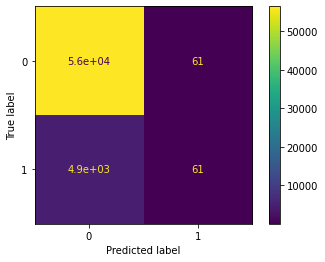

In [ ]:
# plot confusion matrix
plot_confusion_matrix(logistic_clf, x_test, y_test)
plt.show()

In [ ]:
# add accuracy score to results table
results.loc[0] = ['Logistic Regression (Baseline)', 'All application data features', np.round(logistic_train_mean_accuracy_score*100, 2), np.round(logistic_test_score*100, 2), np.round(logistic_train_mean_roc_score*100, 2), np.round(logistic_test_roc_score*100, 2), logistic_grid_search.best_params_]

# show results
results

,model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression (Baseline),All application data features,91.92,91.93,76.33,76.66,"{'logistic__C': 0.01, 'logistic__l1_ratio': 0.1}"


#### Feature Importance

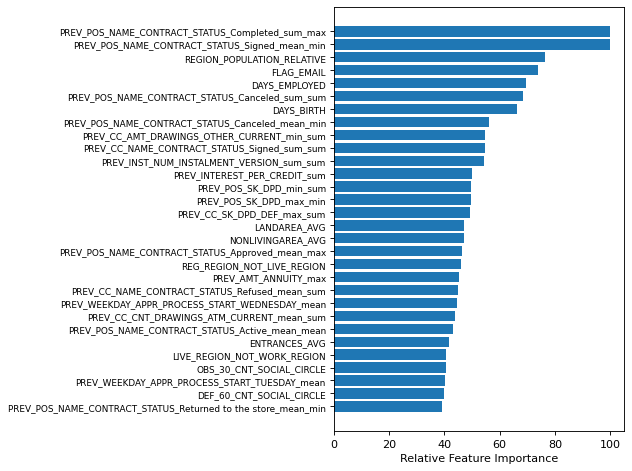

There are 0 features that have 0 importance.


In [ ]:
# plot the feature importance
lr_feature_importance_plot(clf=logistic_clf, names=column_names, n=30)

### Random Forest w/ all file features

In [ ]:
# fit best estimator on entire training data
rf_clf = rf_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
rf_predictions = rf_clf.predict(x_test)

# calculate score on test predictions
rf_test_score = accuracy_score(y_test, rf_predictions)

# calculate roc_auc score on test predictions
rf_test_roc_score = roc_auc_score(y_test, rf_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
rf_test_classification_report = classification_report(y_test, rf_predictions)

# calculate confusion matrix on test predictions
rf_test_confusion_matrix = confusion_matrix(y_test, rf_predictions)

In [ ]:
# display the classification report
print(rf_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



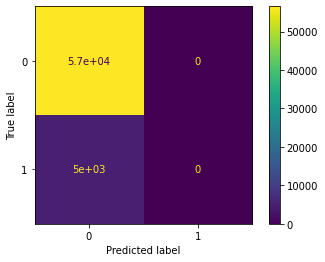

In [ ]:
# plot confusion matrix
plot_confusion_matrix(rf_clf, x_test, y_test)
plt.show()

In [ ]:
# add accuracy score to results table
results.loc[1] = ['Random Forest', 'All application data features w/ all file features', np.round(rf_train_mean_accuracy_score*100, 2), np.round(rf_test_score*100, 2), np.round(rf_train_mean_roc_score*100, 2), np.round(rf_test_roc_score*100, 2), rf_grid_search.best_params_]

# show results
results

,model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
1,Random Forest,All application data features w/ all file feat...,91.93,91.93,72.95,73.38,"{'rf__max_depth': 8, 'rf__max_features': 10, '..."


#### Feature Importance

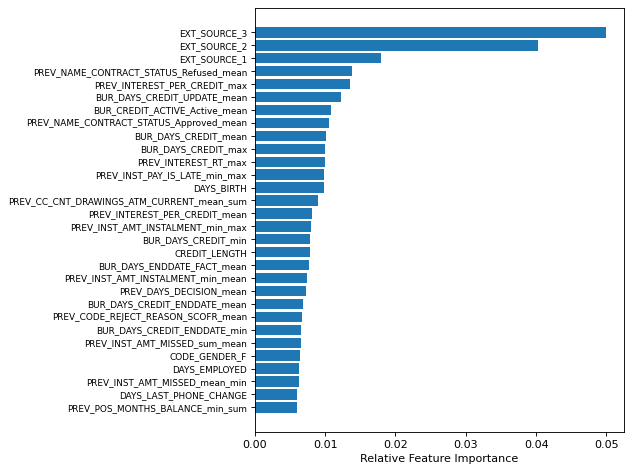

There are 106 features that have 0 importance.


In [ ]:
# plot feature importance
tree_feature_importance_plot(clf=rf_clf, step_name='rf', names=column_names, n=30)

### XGBoost w/ all features

In [ ]:
# fit best estimator on entire training data
xgb_clf = xgb_grid_search.best_estimator_.fit(x_train, y_train)

# generate predictions on test data
xgb_predictions = xgb_clf.predict(x_test)

# calculate score on test predictions
xgb_test_score = accuracy_score(y_test, xgb_predictions)

# calculate roc_auc score on test predictions
xgb_test_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
xgb_test_classification_report = classification_report(y_test, xgb_predictions)

# calculate confusion matrix on test predictions
xgb_test_confusion_matrix = confusion_matrix(y_test, xgb_predictions)

In [ ]:
# display the classification report
print(xgb_test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.64      0.02      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.78      0.51      0.50     61503
weighted avg       0.90      0.92      0.88     61503



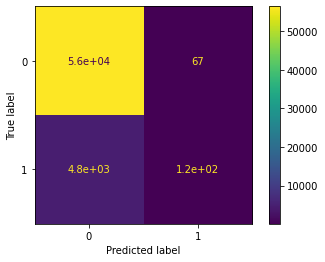

In [ ]:
# plot confusion matrix
plot_confusion_matrix(xgb_clf, x_test, y_test)
plt.show()

In [ ]:
# add accuracy score to results table
results.loc[2] = ['XGBoost', 'All application data features w/ all file features', np.round(xgb_train_mean_accuracy_score*100, 2), np.round(xgb_test_score*100, 2), np.round(xgb_train_mean_roc_score*100, 2), np.round(xgb_test_roc_score*100, 2), xgb_grid_search.best_params_]

# show results
results

,model,Experiment,Train Accuracy,Test Accuracy,Train Area under ROC,Test Area under ROC,Best Parameters
1,Random Forest,All application data features w/ all file feat...,91.93,91.93,72.95,73.38,"{'rf__max_depth': 8, 'rf__max_features': 10, '..."
2,XGBoost,All application data features w/ all file feat...,91.97,92.01,77.85,78.30,"{'xgb__colsample_bytree': 0.1, 'xgb__learning_..."


#### Feature Importance

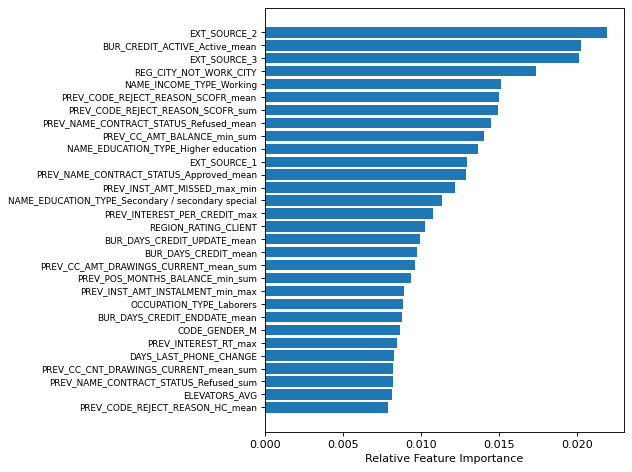

There are 455 features that have 0 importance.


In [ ]:
# plot feature importance
tree_feature_importance_plot(clf=xgb_clf, step_name='xgb', names=column_names, n=30)

# Kaggle Submission

In [ ]:
# predict the test data
predictions = xgb_clf.predict_proba(appTestDF)[:, 1]

In [ ]:
# kaggle submission
submission = pd.DataFrame({'SK_ID_CURR':appTestDF['SK_ID_CURR'],'TARGET':predictions})

submission.head()

,SK_ID_CURR,TARGET
0,100001,0.057599
1,100005,0.129522
2,100013,0.030543
3,100028,0.039786
4,100038,0.132186


In [ ]:
# write out kaggle submission file
filename = SUBMISSION_DIR + '/hcdr_kaggle_submission_phase2.csv'

submission.to_csv(filename,index=False)

# Run time calculation

In [ ]:
# temp time check - remove before submission
print("Start time is ", begin_time)
print("End time is ", datetime.datetime.now())
print("Run time is ", datetime.datetime.now() - begin_time)

Start time is  2021-04-21 06:08:15.058419
End time is  2021-04-21 09:07:47.571998
Run time is  2:59:32.513660
